## Final Project - Summer 2017 ##

__Due 5PM, August 4, 2017__

Complete an analysis of the human leg while riding a bicycle.  The goal of the project is to determine the optimum seat height in order to maximum the power output at the rear wheel of the bike.  Model the leg and bike crank as a fourbar linkage.  Be sure to list and justify an assumptions you make while doing the analysis.  The final results should clearly state the optimum height while also showing supporting plots & figures.  

## Required Sections ##

- Problem Statement
- Assumptions
- Analysis
- Results
- Conclusion

## Requirements: ##

- Determine actual link lengths using actual measurements.  Show picture(s) of how lengths were derived.  Use standard crank lengths commercially available.
- Schematic diagram showing 4bar model to scale (SolidWorks, Illustrator, etc.). Possibly overlay this over real pictures, or show side by side.
- Calculate the max & min seat height that allows the user to maintain contact with pedals at all times.
  - __Note__: max determined by leg length, min determined by mobilty limitation (assumption based)
- Generate polynomial least-squares fit relating leg extension force to knee-angle.
- Generate function to calculate transmission angle based on $\theta_{1}$
- Generate analysis that calculates effective torque as a function of crank angle.  Be sure to use transmission angles to determine the tangential force applied at the pedal.
- Determine optimum seat height to maximize total effective work per rotation.
  - __Note__: If you cannot find the optimum height, show at least 5 evenly spaced seat heights including the max and min.
- Plot effective torque as a function of crank angle (theta3)
  - Plot for max seat height, min seat height, optimum seat height
  - Can use xy-plot or polar
- Assuming RPM of 60, calculate total input power.
  - __Note__: Assume straight extension of leg and user simple power (Work / time).  Work can be found by taking the area under the curve relating force and leg extension measured as a distance (Work = $\int F dx$).  You will need to convert your function F($\theta$) to a function F(x).  This can be done using the link lengths assuming crank length is 0. 
- Assuming RPM of 60, calculate total effective power output.
  - __Note__: Work can be found by taking the area under the curve relating torque and angular displacement (Work = $\int \tau d\theta$).
- Using the drag equation, calculate the maximum velocity of the rider.  You can ignore all losses other that aerodynamic drag.

## References ##

<a href='https://msis.jsc.nasa.gov/sections/section04.htm#_4.9_STRENGTH'>NASA Biometric Strength Study</a>

<img src="https://msis.jsc.nasa.gov/images/Section04/Image137.gif">

<a href="https://breakingmuscle.com/learn/adjust-your-crank-length-for-stronger-cycling">Bike Crank Length Discussion</a>

<img src="https://cdn3.omidoo.com/sites/default/files/imagecache/full/images/bydate/201502/figure2.png">

<a href="https://en.wikipedia.org/wiki/Torque#Units">Discussion of Torque Units</a>

#### Minimum Seat Height Reference Image ####

<img src="https://farm5.static.flickr.com/4121/4879479469_6b6c505c41_b.jpg" width="800px">

<a href="https://www.sram.com/sram/road/products/sram-red-crankset-1#sm.00001vmgp2psfle8yqtc3hmoj5waf">Crank Arm Lengths Available</a>

<img src="https://sram-cdn-pull-zone-gsdesign.netdna-ssl.com/cdn/farfuture/asNivlir-lK0OZ0Jz4DoYeNhK3h1EYvrw8VeThkwfl4/mtime:1454692353/sites/default/files/styles/product_hero_new/public/images/products/cranksets/sr_red_crank_bb30_5339_black_front_l.jpg?itok=sROIoZA-">

#### Transmission Angle ####

<img src="https://jrmcclure.com/MAE4120/images/Transmission1.jpg">

#### Drag Equation References ####

- <a href="http://www.analyticcycling.com/ForcesPower_Page.html">Forces on Rider</a>
- <a href="http://www.analyticcycling.com/ForcesPower_Page.html">Bicycle Drag Force</a>


In [7]:
%matplotlib inline

In [8]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import fsolve

In [9]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from matplotlib import animation, rc
from IPython.display import HTML

In [10]:
def fourbar_theta1_min(a,b,c,d):
    '''
    Function returns theta1_min if exists, else returns None
    '''    
    if (c + b) < (d - a):
        return None
    elif (c - b) > (d + a):
        return None
    elif ((c + b) >= (d - a)) and ((c - b) <= (d - a)):
        if ((c + b) >= (d + a)) and ((c - b) <= (d + a)):
            return 0 
        else:
            def equations(p):
                x, y = p
                return (
                    a * math.cos(x) - d - (c + b) * math.cos(y),
                    a * math.sin(x) - (c + b) * math.sin(y)
                )
            t1_max, t3 =  fsolve(equations, (math.pi/2 , math.pi))
            return 0 - math.degrees(t1_max)
    else:
        def equations(p):
            x, y = p
            return (
                a * math.cos(x) - d - (c - b) * math.cos(y),
                a * math.sin(x) - (c - b) * math.sin(y)
            )
        t1_min, t3 =  fsolve(equations, (math.pi/4 , math.pi))
        return math.degrees(t1_min)

In [19]:
def fourbar_theta1_min_alt(a,b,c,d):
    
    for theta1 in np.arange(0,360,0.01):

        t1 = math.radians(theta1)
        
        k1 = d / a
        k2 = d / c
        k3 = (a**2 - b**2 + c**2 + d**2) /  (2 * a * c)

        A = math.cos(t1) - k1 - k2 * math.cos(t1) + k3
        B = -2 * math.sin(t1)
        C = k1 - (k2 + 1) * math.cos(t1) + k3
            
        if (B**2 - 4*A*C) >= 0:
            return theta1

    return None

In [20]:
print(fourbar_theta1_min(200,150,800,800))
print(fourbar_theta1_min(150,250,750,600))
print(fourbar_theta1_min(150,300,500,600))

36.419913728560296
42.59881289236288
0


In [21]:
print(fourbar_theta1_min_alt(200,150,800,800))
print(fourbar_theta1_min_alt(150,250,750,600))
print(fourbar_theta1_min_alt(150,300,500,600))

36.42
42.6
0.0


In [24]:
def fourbar_df_plot(x1,y1,x2,y2,x3,y3,x4,y4):
    # Setup figure and subplots
    f0 = plt.figure()
    ax = plt.subplot()

    ax.set_aspect('equal')

    L1x = x1,x2
    L1y = y1,y2
    L2x = x2,x3
    L2y = y2,y3
    L3x = x3,x4
    L3y = y3,y4
    L4x = x4,x1
    L4y = y4,y1

    # Add data to the plot
    pL1, = ax.plot(L1x, L1y)
    pL2, = ax.plot(L2x, L2y)
    pL3, = ax.plot(L3x, L3y)
    pL4, = ax.plot(L4x, L4y)
    plt.show()

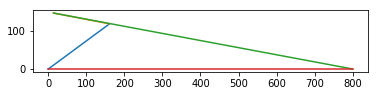

In [25]:
fourbar_df_plot(0,0,160.9354276,118.7425288,13.63993491,147.0980898,800,0)

### Notes: ###

- Assumptions:
  - Symmetry
  - Mobility Limit
  - Application of force on pedal

#### Measurements ####
- Femur = 42 cm
- Tibia = 43 cm